In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from ipywidgets import IntProgress
from tqdm import tqdm
from PIL import Image

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.2.0
Torchvision Version:  0.4.0


In [3]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [4]:
#!unzip drive/'My Drive'/frame_filter.zip 

In [5]:
!nvidia-smi

Fri Sep 18 15:01:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |  10013MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
train = pd.read_csv('data/train.csv', index_col=[0])
val = pd.read_csv('data/val.csv', index_col=[0])
mapper = {"neg": 0, "pos": 1}

In [7]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 30

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True



In [8]:


class FootballFrameDataset(object):
    
    def __init__(self, df, transforms = None, normalize = False, size=(299, 299)):
                 
        self.network_size = size
        self.normalize = normalize
        self.transforms = transforms
        
        self.imgs = []
        self.labels = []
        for num, info in df.iterrows():
            img_path = os.path.join(info.root, info.img_name)
            self.imgs.append(img_path)
            self.labels.append(info.frame)
            
    def __getitem__(self, idx):
            
        #img = cv2.cvtColor(cv2.imread(self.imgs[idx]), cv2.COLOR_RGB2BGR) 
        #img = cv2.resize(img, self.network_size)
        #img =         
        img = Image.open(self.imgs[idx])
        img = img.resize(self.network_size, Image.ANTIALIAS)
            
        target = mapper[self.labels[idx]]
        
        

            
            
        if self.transforms is not None:
            #img = Image.fromarray(np.uint8(img*255))
            img = self.transforms(img)
            
        img = np.array(img)
        img = np.moveaxis(img, -1, -0).astype(np.float32)
        if self.normalize:
            img  *= (1. / 255)
        return img, target
    
    def __len__(self):
        return len(self.imgs)


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        torchvision.transforms.RandomGrayscale(p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])
}

In [10]:
train_data = FootballFrameDataset(train, transforms=data_transforms['train'], normalize=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

val_data = FootballFrameDataset(val, transforms=None, normalize=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda', index=0)

In [16]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [17]:
dataloaders_dict = {"train": train_loader, "val": val_loader}

In [18]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.4697 Acc: 0.8628


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1830 Acc: 0.9565

Epoch 1/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2071 Acc: 0.9652


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1211 Acc: 0.9772

Epoch 2/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1898 Acc: 0.9606


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1083 Acc: 0.9855

Epoch 3/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1583 Acc: 0.9664


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0994 Acc: 0.9834

Epoch 4/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1504 Acc: 0.9656


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0971 Acc: 0.9814

Epoch 5/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1317 Acc: 0.9744


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0897 Acc: 0.9814

Epoch 6/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1247 Acc: 0.9719


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0869 Acc: 0.9814

Epoch 7/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1178 Acc: 0.9723


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0860 Acc: 0.9793

Epoch 8/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1169 Acc: 0.9748


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0855 Acc: 0.9814

Epoch 9/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1243 Acc: 0.9702


100%|██████████| 17/17 [01:22<00:00,  4.85s/it]

val Loss: 0.0839 Acc: 0.9793

Training complete in 52m 8s
Best val Acc: 0.985507


In [19]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.7730 Acc: 0.6991


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 1.1476 Acc: 0.6625

Epoch 1/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.4657 Acc: 0.8632


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.4656 Acc: 0.8054

Epoch 2/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.3529 Acc: 0.8980


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.3152 Acc: 0.8716

Epoch 3/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2991 Acc: 0.9186


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2872 Acc: 0.8861

Epoch 4/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2305 Acc: 0.9417


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2703 Acc: 0.8861

Epoch 5/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2094 Acc: 0.9454


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.3118 Acc: 0.8820

Epoch 6/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1905 Acc: 0.9509


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2647 Acc: 0.9068

Epoch 7/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1936 Acc: 0.9509


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2067 Acc: 0.9213

Epoch 8/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1819 Acc: 0.9501


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1978 Acc: 0.9193

Epoch 9/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1747 Acc: 0.9547


100%|██████████| 17/17 [01:25<00:00,  5.01s/it]

val Loss: 0.2601 Acc: 0.9234

Training complete in 56m 34s
Best val Acc: 0.923395


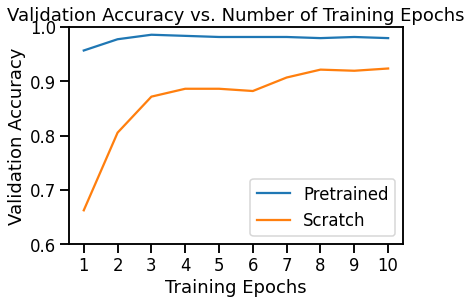

In [35]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0.6,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# test set

In [117]:
test = pd.read_csv('data/test.csv', index_col=[0])

In [118]:
test_data = FootballFrameDataset(test, transforms=None, normalize=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True, num_workers=0)

In [137]:
batch_pred

tensor([[ 3.2002, -2.9872],
        [-0.2365,  0.2875]], device='cuda:0')

In [132]:
scratch_model.eval()
y_pred = []
y_true = []

for inputs, labels in tqdm(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        batch_pred = scratch_model(inputs)
        _, preds = torch.max(batch_pred, 1)
        
        y_pred.extend(preds.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())


100%|██████████| 12/12 [00:21<00:00,  1.78s/it]


In [133]:
from sklearn.metrics import confusion_matrix

In [134]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [135]:
import numpy as np
import seaborn as sns
from cf_matrix import make_confusion_matrix
sns.set_context('talk')

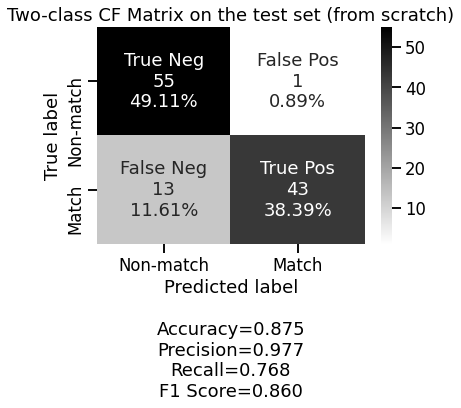

In [136]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-match' ,'Match']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='binary', title='Two-class CF Matrix on the test set (from scratch)')

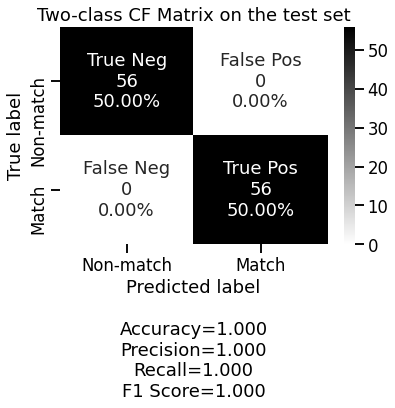

In [45]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-match' ,'Match']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='binary', title='Two-class CF Matrix on the test set')

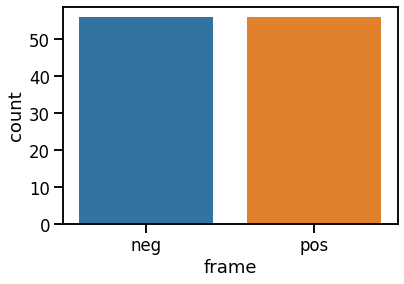

In [46]:
sns.countplot(test.frame)

In [56]:
torch.save(scratch_model.state_dict(), 'Scratch_CP_epoch_{}.pth'.format(num_epochs + 1))

In [57]:
torch.save(model_ft.state_dict(), 'Pretrained_CP_epoch_{}.pth'.format(num_epochs + 1))

In [214]:
def eval_model_test_set(model, test_path, batch_size):
    """
    Function that test a given model on a secret test set (no labels given) and retuns a csv with img_name, prediction
    :param model: pytorch model object
    :param test_path:
    :param batch_size:
    :return dataframe: || filename | probability of an instance being a match frame ||
    """
    
    model.eval()


    test_batch = np.zeros((batch_size, 3, 299, 299))
    filenames = []
    labels = []
    counter = 0
    for ind, img_name in tqdm(enumerate(os.listdir(secret_path))):    
        if img_name.endswith('.jpg'):
            filenames.append(img_name)
            img_path = os.path.join(secret_path, img_name)

            img = Image.open(img_path)
            img = img.resize((299,299), Image.ANTIALIAS)
            img = np.array(img)
            img = img * (1. / 255)
            img = np.moveaxis(img, -1, 0).astype(np.float32)

            test_batch[counter] = img
            counter += 1


            if counter==(batch_size):
                test_batch = torch.from_numpy(test_batch).float()
                test_batch = test_batch.to(device=device, dtype=torch.float32)

                with torch.no_grad():
                    batch_pred = model(test_batch)
                    _, preds = torch.max(batch_pred, 1)
                    m = nn.Softmax(dim=0)
                    softmax_output = m(batch_pred)
                    probs, preds = torch.max(softmax_output, 1)
                    #print(ind, preds)

                test_batch = np.zeros((batch_size, 3, 299, 299))
                counter = 0

                labels.extend(probs.cpu().numpy().tolist())
                
    s = pd.DataFrame([],columns = ['filename', 'probability'])
    s['filename'] = filenames
    s['probability'] = labels
    return s


In [215]:
secret_path = "data/FrameFilter-test_set"
batch_size = 10

In [216]:
result_pretrained = eval_model_test_set(model = model_ft,
                                        test_path = secret_path,
                                        batch_size = batch_size)

601it [00:31, 18.81it/s]


In [217]:
result_scratch = eval_model_test_set(model = scratch_model,
                                     test_path = secret_path,
                                     batch_size = batch_size)

601it [00:32, 18.72it/s]


In [223]:
result_pretrained.probability.min()

0.030614599585533142

In [225]:
result_scratch.probability.max()

0.9998728036880493